In [1]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#16a085', '#e8f6f3', '#d0ece7', '#a2d9ce', '#73c6b6', '#45b39d', 
                        '#16a085', '#138d75', '#117a65', '#0e6655', '#0b5345']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = ''' 

div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s; /* light orange */
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s; /* light orange */
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
    border-top: 2px solid %s; /* light orange */
}

div.input_prompt {
color: %s; /* light blue */
}

div.output_prompt {
color: %s; /* strong orange */
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s; /* light orange */
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s; /* light orange */
}

.edit_mode div.cell.selected:before {
background: %s; /* light orange */
}

.edit_mode div.cell.selected {
border-color: %s; /* light orange */

}
'''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

/tmp/ipykernel_3574377/1016028258.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML). 

### Do not forget to put upvote for the notebook, follow me on Kaggle and the ⭐️ for github repo if you like it - one click for you, great pleasure for us ☺️ 
### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [2]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

/home/alexey/anaconda3/lib/python3.9/site-packages/IPython/core/display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

In [3]:
!pip install lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip install -U pandas

  Using cached pandas-1.4.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.0.0 requires requests<2.29,>=2.24.0, but you have requests 2.22.0 which is incompatible.
  Using cached pandas-1.5.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.3
    Uninstalling pandas-1.4.3:
      Successfully uninstalled pandas-1.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.0.0 requires requests<2.29,>=2.

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [4]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# Some useful libraries for data preprocessing
import json
import difflib

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [5]:
N_THREADS = 12
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 900 # equal to 15 minutes
TARGET_NAME = 'final_price'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [6]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [7]:
INPUT_DIR = './input/sf-dst-predict-car-price/'
ADDITIONAL_DIR = './input/predict-car-price/'

In [8]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [9]:
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [10]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### Step 0.5. Some user feature preparation. Let's make some data preprocessing based on results of EDA (<a href="https://github.com/alexey300479/sf_datascience_2022/blob/master/KAGGLE_PREDICT_CAR_PRICE/car_price_eda.ipynb">details here</a>)

Be creative :)

Install <a href="https://github.com/nighcoder/vin-parser">vin-parser</a> library to process VIN codes.

In [11]:
!pip install -U vin_parser

In [12]:
import vin_parser as vp

Define some useful functions:

In [13]:
def fillna_by_mode(df, column: str) -> None:
    """
    Filling missing values in 'feature' column of pandas.DataFrame df by
    most frequent value of this column (mode),
    prompt mission values count before and after filling,
    and make shure of there is no missing values after that.

    Args:
        df (pandas.DataFrame): Pandas DataFrame to fill missing values 
        column (str): Column name
    """
    
    # Find most frequent value (mode)
    mode = df[column].mode().values[0]
    
    # Fill missing values by most frequent value
    df[column].fillna(mode, inplace=True)
    
    # Zero missing values check
    if df[column].isna().sum():
        raise RuntimeError('Missing values count is not equal zero after pandas.Series.fillna!')


def clear_string_value(value: str) -> str:
    """
    Remove heading and trailing spaces from value or return None if value is not str

    Args:
        value (str): input string with headinng and trailing spaces

    Returns:
        str: clear output sting or None
    """
    
    return value.strip().lower() if isinstance(value, str) else None


def get_country(vin: str):
    if vin == 'no' or len(vin) != 17:
        return 'no'
    country = vp.country(vin)
    return 'no' if country is None else country


def get_model_year(vin: str) -> int:
    if vin == 'no' or len(vin) != 17:
        return 0
    year = vp.year(vin)
    return 0 if year is None else year


def get_best_match_model(manufacturer: str, model: str) -> str:
    """
    Return best match model from car models base, or itself if not found

    Args:
        manufacturer (str): manufacturer name in lower case without heading and trailing spaces
        model (str): model name (can be with typos)

    Returns:
        str: best match model or itself if not found
    """
    
    vehicle_models = manufacturers_models[manufacturers_models.mark == manufacturer].model.unique()
    
    best_match_models = difflib.get_close_matches(model, vehicle_models)
    if best_match_models:
        return best_match_models[0]
    
    return model


def get_doors_cnt(vehicle_category: str, doors_cnt: str) -> int:
    if vehicle_category == 'limousine':
        return 4
    
    if vehicle_category in {'sedan', 'pickup', 'cabriolet'}:
        if doors_cnt == '2/3':
            return 2
        if doors_cnt == '4/5':
            return 4
        return 6
    
    if doors_cnt == '2/3':
        return 3
    
    if doors_cnt == '4/5':
        return 5
    
    return 7


def one_digit(s):
    if len(s) == 1:
        return True
    return False if s[0] != s[1] else one_digit(s[1:])


def str_miles(m):
    if m >= 500000 or m == 0:
        return 0
    s = str(m)
    return 0 if m > 1000 and one_digit(s) else np.log10(m)



Prepare car manufacturers and models dataset

In [14]:
# Load dataset
manufacturers_models = pd.read_csv(ADDITIONAL_DIR + 'cars.csv', sep=';')
# Bring all texts to lowercase, remove heading and trailing spaces
manufacturers_models.model = manufacturers_models.model.apply(clear_string_value)
manufacturers_models.mark = manufacturers_models.mark.apply(clear_string_value)

Prepare dictionary to translate car models from gerogian

In [15]:
with open(ADDITIONAL_DIR + 'models_dict.json') as f:
    models_dict = json.load(f)

In [16]:
len(models_dict)

2479

Compute maximum value of vehicle_year of both train and test datasets to compute vehicle age

In [17]:
max_year = max(
    train_data.vehicle_year.max(),
    test_data.vehicle_year.max())

In [18]:
%%time

def create_expert_feats(data, train=False, drop_duplicates=False, model_translate=True, mileage_limit=True, mileage_log=True):
    global manufacturers_models
    global models_dict
    global max_year
    
    # Clear duplicates if train data
    if drop_duplicates:
        data.drop_duplicates(subset=data.columns[1:], inplace=True)
    
    # Clear text data
    object_cols = data.select_dtypes('object').columns
    for col in object_cols:
        data[col] = data[col].apply(clear_string_value)
    
    # car_vin processing
    # first fill missing values by 'no'
    data['car_vin'].fillna('no', inplace=True)
    
    # extract manuf country
    data['manuf_country'] = data.car_vin.apply(get_country)
    
    # extract model year
    data['model_year'] = data.car_vin.apply(get_model_year)
    
    # finally drop car_vin column
    data.drop(columns=['car_vin'], inplace=True)
    
    # fill missing values in vehicle_interior_color by mode
    fillna_by_mode(data, 'vehicle_interior_color')
    
    # fill missing values in doors_cnt by mode
    fillna_by_mode(data, 'doors_cnt')
    
    # fill missing values in vehicle_color by mode
    fillna_by_mode(data, 'vehicle_color')
    
    # clear 'vehicle_manufacturer'
    if train:
        # заполнение строк с таргетом = 0, удаление 5ти выбросов со стоимостью > 200 тыс и 1 со стоимостью 111111
        data.loc[2856, 'final_price'] = 38
        data.loc[3146, 'final_price'] = 13
        data.loc[7123, 'final_price'] = 2000
        data = data[(data['final_price'] <= 200000)&(data['final_price'] != 111111)]
        
        data['final_price'] = data['final_price'].astype(np.int32)
        
        data.drop([17918], axis='rows', inplace=True)
        data.loc[8931, 'vehicle_manufacturer'] = 'fude'
        data.loc[31178, 'vehicle_manufacturer'] = 'iveco'
        data.drop([18638], axis='rows', inplace=True)
        data.loc[4821, 'vehicle_manufacturer'] = 'kamaz'
        data.loc[8176, 'vehicle_manufacturer'] = 'proton'
        data.loc[9589, 'vehicle_manufacturer'] = 'gonow'
        
        strange_cars_idx = data[data.vehicle_manufacturer == 'სხვა'].index
        data.drop(strange_cars_idx, axis='rows', inplace=True)
    
    # clear 'vehicle_model' from missing values
    data.fillna('no', inplace=True)
    
    if model_translate:
        # Translate car models from georgian 
        models = data.vehicle_model.unique()
        data.vehicle_model = data.vehicle_model.map(models_dict)
        data.vehicle_model = data.vehicle_model.apply(clear_string_value)
    
    
        # Revome ' urently' from car models
        data.vehicle_model = data.vehicle_model.apply(lambda x: x.replace(' urgently', ''))

        # Bring dataset car models to standard car model names from cars.csv dataset
        data.vehicle_model = data[['vehicle_manufacturer', 'vehicle_model']].apply(
            lambda x: get_best_match_model(
                x['vehicle_manufacturer'],
                x['vehicle_model']), axis=1)
    
    
    if mileage_limit:
        # Limit maximum value of car_mileage to 1_000_000
        data.current_mileage = data.current_mileage.apply(lambda x: min(x, 1_000_000))

    if mileage_log:
        # Apply logarifm to car_mileage
        data.current_mileage = data.current_mileage.apply(lambda x: x or 1)
        data.current_mileage = np.log(data.current_mileage)

    # Create vehicle_age feature from vehicle_year 
    data['vehicle_age'] = max_year - data.vehicle_year
    
    # Drop vehicle_year
    data.drop(columns=['vehicle_year'], inplace=True)
    
    # Transform doors_cnt from 'object' (exactly categorical)
    # type to int (exact doors count) depending on vehicle_category
    data.doors_cnt = data[['vehicle_category', 'doors_cnt']].apply(
        lambda x: get_doors_cnt(
            x['vehicle_category'],
            x['doors_cnt']), axis=1)
    
    # Sure that no missing values is in data
    if data.isna().sum().sum():
        raise RuntimeError('There is missing values in data after preprocessing')


create_expert_feats(train_data, train=True, drop_duplicates=True)
create_expert_feats(test_data)

<timed exec>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

CPU times: user 38.1 s, sys: 36.4 ms, total: 38.2 s
Wall time: 38.2 s


In [19]:
train_data.iloc[7123]

row_ID                          8260
vehicle_manufacturer       ssangyong
vehicle_model                 rexton
vehicle_category                jeep
current_mileage                64459
vehicle_year                    2008
vehicle_gearbox_type       automatic
doors_cnt                        4/5
wheels                    left wheel
vehicle_color                 silver
vehicle_interior_color         black
car_leather_interior               1
deal_type                   for sale
final_price                   2700.0
manuf_country                     no
model_year                         0
Name: 8260, dtype: object

In [20]:
train_data.shape

(26928, 16)

In [21]:
test_data.shape

(10697, 15)

### 0.6. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [22]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (21542, 16), te_data = (5386, 16)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price,manuf_country,model_year
2724,2724,toyota,prius,sedan,165000,2012,automatic,4/5,left wheel,sky blue,black,0,for sale,5300.0,no,0
31266,31266,honda,fit,hatchback,120000,2012,tiptronic,4/5,right-hand drive,black,black,0,for sale,4700.0,no,0
17338,17338,toyota,rav 4,jeep,55362,2017,automatic,4/5,left wheel,blue,black,1,for sale,5800.0,Japan,2017
16973,16973,mercedes-benz,e 300,sedan,11111,1995,automatic,4/5,left wheel,silver,black,0,for sale,1700.0,no,0
32599,32599,volkswagen,jetta,sedan,45000,2016,manual,4/5,left wheel,grey,black,0,for sale,6700.0,no,0


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [23]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [24]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [25]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [26]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[13:07:57] Stdout logging level is INFO.
[13:07:57] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[13:07:57] Task: reg

[13:07:57] Start automl preset with listed constraints:
[13:07:57] - time: 900.00 seconds
[13:07:57] - CPU: 12 cores
[13:07:57] - memory: 16 GB

[13:07:57] Train data shape: (21542, 16)

[13:08:09] Layer 1 train process start. Time left 887.43 secs


/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarnin

[13:08:10] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))


[13:09:09] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -4153.925933033939
[13:09:09] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[13:09:09] Time left 827.24 secs



/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarnin

[13:09:55] Selector_LightGBM fitting and predicting completed
[13:09:56] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
/home/alexey/anaconda3/lib/python3.9/site-packages/lightautoml/transformers/categorical.py:1029: FutureWarnin

[13:11:19] Time limit exceeded after calculating fold 3

[13:11:19] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -3186.4929604634663
[13:11:19] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[13:11:19] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 1.00 secs
[13:14:08] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[13:14:08] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU


[13:14:36] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -3428.0407881118067
[13:14:36] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[13:14:36] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 213.97 secs


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric perio

[13:18:17] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[13:18:17] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU
Default metric period is 5 because MAE is/are not implemented for GPU


[13:18:44] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -3362.635329305478
[13:18:44] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[13:18:44] Time left 252.63 secs

[13:18:44] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[13:18:44] Layer 1 training completed.

[13:18:44] Blending: optimization starts with equal weights and score -3464.385961637049
[13:18:44] Blending: iteration 0: score = -3328.824773955025, weights = [0.         0.65512425 0.         0.34487572]
[13:18:44] Blending: iteration 1: score = -3328.824773955025, weights = [0.         0.65512425 0.         0.34487572]
[13:18:44] Blending: no score update. Terminated

[13:18:44] Automl preset training completed in 647.48 seconds

[13:18:44] Model description:
Final prediction for new objects (level 0) = 
	 0.65512 * (4 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.34488 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 

CPU times: user 38min 2s, s

In [27]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.65512 * (4 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.34488 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [28]:
%%time

te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[ 8505.755 ],
       [15111.047 ],
       [ 4275.4014],
       ...,
       [10460.537 ],
       [ 4276.856 ],
       [ 2369.9365]], dtype=float32)
Shape = (5386, 1)
CPU times: user 8.44 s, sys: 1.66 s, total: 10.1 s
Wall time: 1.32 s


In [29]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

TRAIN out-of-fold score: 3328.824773955025
HOLDOUT score: 2188.898538055448


# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

CPU times: user 80.1 ms, sys: 4.13 ms, total: 84.2 ms
Wall time: 83.4 ms


<AxesSubplot: xlabel='Feature'>

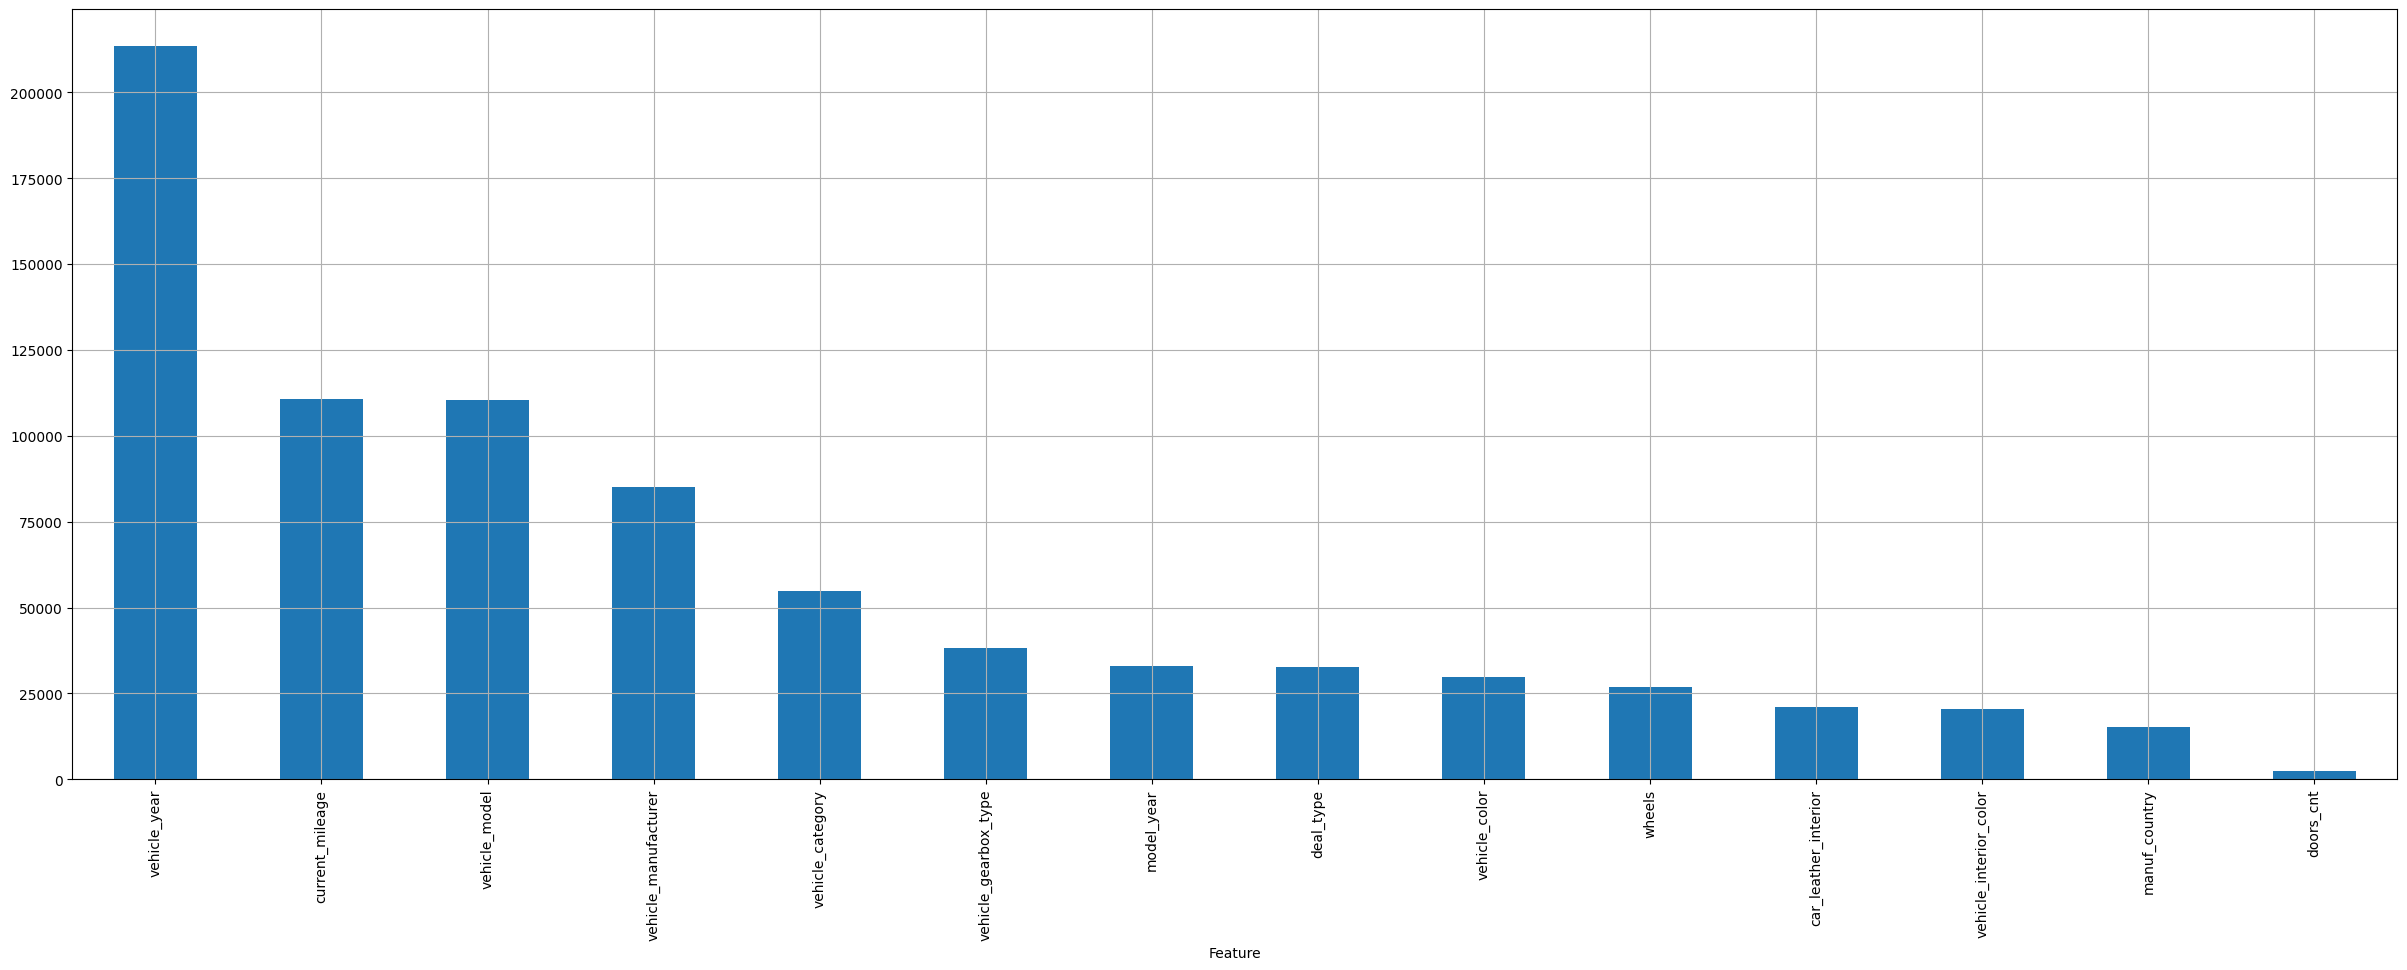

In [30]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [31]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

CPU times: user 1min 53s, sys: 27.3 s, total: 2min 21s
Wall time: 16 s


<AxesSubplot: xlabel='Feature'>

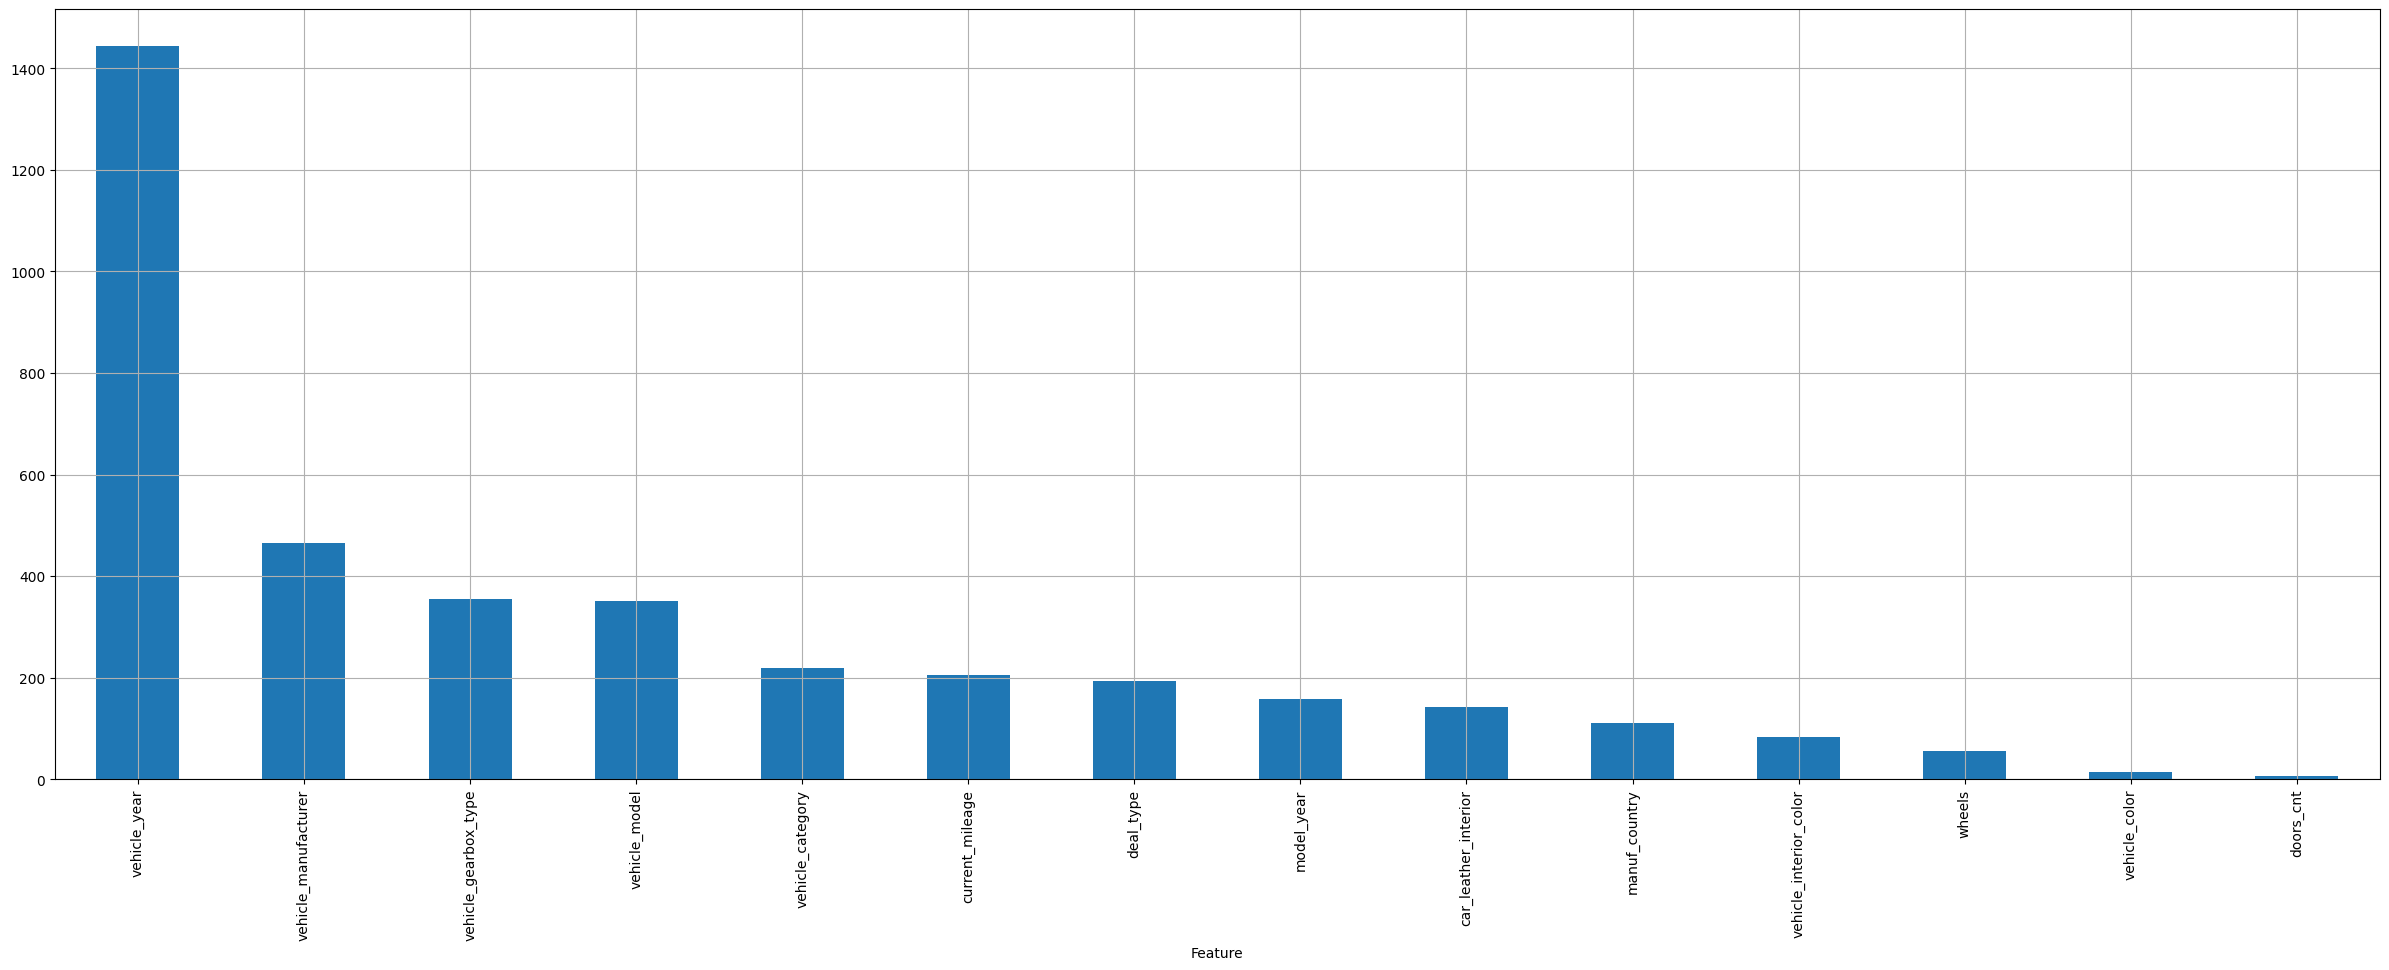

In [32]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

In [33]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

KeyError: "['vehicle_year'] not in index"

In [ ]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.to_csv('lightautoml_tabularautoml.csv', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [ ]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)